# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [12]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at ../data/raw/outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

## Data Visualization: Complete Dataset Analysis


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the data
df = pd.read_csv('../data/raw/outliers_homework.csv')
df['date'] = pd.to_datetime(df['date'])

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total trading days: {len(df)}")
print("\nFirst few rows:")
print(df.head())


In [ ]:
# Create comprehensive visualization with all data points
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Time Series Plot - Both Returns Over Time
axes[0,0].plot(df['date'], df['daily_return'], label='Daily Return 1', alpha=0.8, linewidth=1.2, color='steelblue')
axes[0,0].plot(df['date'], df['daily_return_2'], label='Daily Return 2', alpha=0.8, linewidth=1.2, color='coral')
axes[0,0].set_title('Time Series: Daily Returns (All Data Points)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Daily Return')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Highlight potential outliers (shock periods in May 2022)
shock_dates = ['2022-05-02', '2022-05-03', '2022-05-06', '2022-05-09', '2022-05-12']
for shock_date in shock_dates:
    shock_mask = df['date'] == pd.to_datetime(shock_date)
    if shock_mask.any():
        axes[0,0].scatter(df.loc[shock_mask, 'date'], df.loc[shock_mask, 'daily_return'], 
                         color='red', s=80, alpha=0.8, zorder=5)

# 2. Scatter Plot - Correlation Between Returns
axes[0,1].scatter(df['daily_return'], df['daily_return_2'], alpha=0.6, s=30, color='darkgreen')
axes[0,1].set_title('Scatter Plot: Return 1 vs Return 2 Correlation', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Daily Return 1')
axes[0,1].set_ylabel('Daily Return 2')
axes[0,1].grid(True, alpha=0.3)

# Add correlation coefficient
correlation = df['daily_return'].corr(df['daily_return_2'])
axes[0,1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
               transform=axes[0,1].transAxes, fontsize=12, 
               bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

# 3. Distribution Histograms
axes[1,0].hist(df['daily_return'], bins=30, alpha=0.7, label='Daily Return 1', color='steelblue', density=True)
axes[1,0].hist(df['daily_return_2'], bins=30, alpha=0.7, label='Daily Return 2', color='coral', density=True)
axes[1,0].set_title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Return Value')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Box Plots for Outlier Detection
box_data = [df['daily_return'], df['daily_return_2']]
box_plot = axes[1,1].boxplot(box_data, labels=['Daily Return 1', 'Daily Return 2'], patch_artist=True)
axes[1,1].set_title('Box Plots: Outlier Detection', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Return Value')
axes[1,1].grid(True, alpha=0.3)

# Color the box plots
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.tight_layout()
plt.savefig('../data/processed/complete_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("COMPLETE DATASET STATISTICS")
print("="*60)
print("\nDaily Return 1:")
print(df['daily_return'].describe())
print("\nDaily Return 2:")
print(df['daily_return_2'].describe())


In [ ]:
# Additional Analysis: Individual Data Point Patterns
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Rolling Statistics to Show Data Patterns
window = 10
df['rolling_mean_1'] = df['daily_return'].rolling(window=window).mean()
df['rolling_std_1'] = df['daily_return'].rolling(window=window).std()

axes[0].plot(df['date'], df['daily_return'], 'o-', alpha=0.6, markersize=3, label='Daily Returns', color='navy')
axes[0].plot(df['date'], df['rolling_mean_1'], '-', linewidth=2, label=f'{window}-Day Rolling Mean', color='red')
axes[0].fill_between(df['date'], 
                     df['rolling_mean_1'] - 2*df['rolling_std_1'], 
                     df['rolling_mean_1'] + 2*df['rolling_std_1'], 
                     alpha=0.2, color='red', label='±2σ Band')
axes[0].set_title('Daily Returns with Rolling Statistics (All 116 Data Points)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Daily Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Cumulative Returns to Show Overall Trend
df['cumulative_return_1'] = (1 + df['daily_return']).cumprod() - 1
df['cumulative_return_2'] = (1 + df['daily_return_2']).cumprod() - 1

axes[1].plot(df['date'], df['cumulative_return_1'], '-', linewidth=2, label='Cumulative Return 1', color='darkblue')
axes[1].plot(df['date'], df['cumulative_return_2'], '-', linewidth=2, label='Cumulative Return 2', color='darkorange')
axes[1].set_title('Cumulative Returns Over Time (Impact of All Data Points)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cumulative Return')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# 3. Volatility Analysis (30-day rolling)
df['volatility'] = df['daily_return'].rolling(window=20).std() * np.sqrt(252)  # Annualized volatility

axes[2].plot(df['date'], df['volatility'], '-', linewidth=2, color='purple', alpha=0.8)
axes[2].fill_between(df['date'], 0, df['volatility'], alpha=0.3, color='purple')
axes[2].set_title('Rolling 20-Day Annualized Volatility', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Annualized Volatility')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/processed/detailed_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Data Point Analysis Summary
print("\n" + "="*60)
print("INDIVIDUAL DATA POINT ANALYSIS")
print("="*60)
print(f"Total data points analyzed: {len(df)}")
print(f"Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Business days covered: {len(df)} trading days")

# Identify extreme values
extreme_positive = df.nlargest(5, 'daily_return')[['date', 'daily_return', 'daily_return_2']]
extreme_negative = df.nsmallest(5, 'daily_return')[['date', 'daily_return', 'daily_return_2']]

print("\n🔺 TOP 5 HIGHEST RETURNS:")
print(extreme_positive.to_string(index=False))

print("\n🔻 TOP 5 LOWEST RETURNS:")
print(extreme_negative.to_string(index=False))

# Volatility periods
high_vol_periods = df[df['volatility'] > df['volatility'].quantile(0.9)][['date', 'daily_return', 'volatility']].dropna()
print(f"\n📊 HIGH VOLATILITY PERIODS (Top 10%):")
print(f"Number of high volatility days: {len(high_vol_periods)}")
if len(high_vol_periods) > 0:
    print("Sample high volatility days:")
    print(high_vol_periods.head().to_string(index=False))


In [ ]:
# Complete Data Table - All 116 Data Points
print("📋 COMPLETE DATASET TABLE")
print("="*80)
print("Showing all data points with additional calculated metrics:\n")

# Add some derived metrics for each data point
df_display = df.copy()
df_display['abs_return'] = abs(df_display['daily_return'])
df_display['return_category'] = pd.cut(df_display['daily_return'], 
                                      bins=[-float('inf'), -0.05, -0.01, 0.01, 0.05, float('inf')],
                                      labels=['Large Loss', 'Small Loss', 'Neutral', 'Small Gain', 'Large Gain'])

# Display first 10 and last 10 rows with key metrics
print("🔍 FIRST 10 DATA POINTS:")
display_cols = ['date', 'daily_return', 'daily_return_2', 'abs_return', 'return_category']
print(df_display[display_cols].head(10).to_string(index=False))

print("\n🔍 LAST 10 DATA POINTS:")
print(df_display[display_cols].tail(10).to_string(index=False))

# Summary by categories
print(f"\n📊 DATA POINT CATEGORIZATION (All {len(df)} points):")
category_summary = df_display['return_category'].value_counts().sort_index()
for category, count in category_summary.items():
    percentage = (count / len(df)) * 100
    print(f"  {category}: {count} days ({percentage:.1f}%)")

# Monthly breakdown
df_display['month'] = df_display['date'].dt.strftime('%Y-%m')
monthly_stats = df_display.groupby('month').agg({
    'daily_return': ['count', 'mean', 'std', 'min', 'max'],
    'daily_return_2': 'mean'
}).round(4)
monthly_stats.columns = ['Days', 'Mean_Return', 'Std_Return', 'Min_Return', 'Max_Return', 'Mean_Return2']

print(f"\n📅 MONTHLY BREAKDOWN (All data points organized by month):")
print(monthly_stats.to_string())

# Save detailed data
detailed_output_path = '../data/processed/complete_data_with_analysis.csv'
df_display.to_csv(detailed_output_path, index=False)
print(f"\n💾 Complete dataset with analysis saved to: {detailed_output_path}")
print(f"   Total data points saved: {len(df_display)}")
print(f"   Columns included: {', '.join(df_display.columns)}")


In [21]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [22]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


## TODO: Implement Outlier Functions (required)

In [23]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [24]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [17]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.005
outlier_z      0.005
dtype: float64

### Visual Checks (boxplot / histogram)

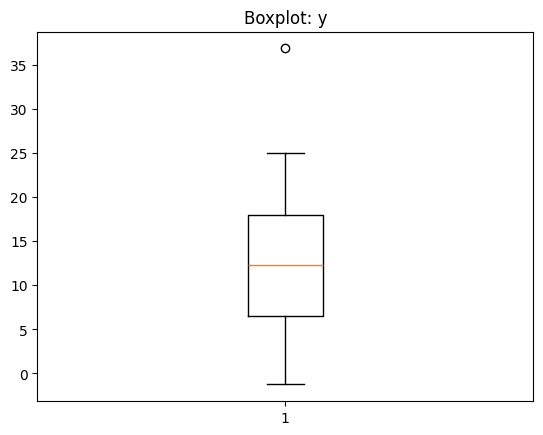

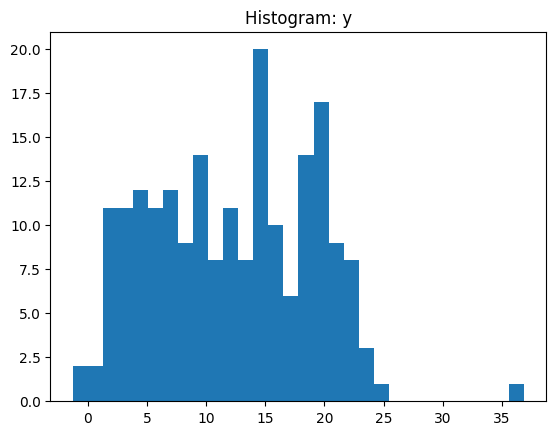

In [18]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [19]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,12.171936,12.047851,12.119643
median,12.349663,12.285113,12.349663
std,6.761378,6.546157,6.386781


In [20]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

*Write your reflection here...*